In [ ]:
# --- Mount Google Drive (Optional but highly recommended) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class DIV2KDataset(Dataset):
    def __init__(self, root_dir, mode="train", upscale_factor=4):
        """
        root_dir: path to dataset directory (should contain 'DIV2K_train_HR' or 'DIV2K_valid_HR')
        mode: "train" or "valid"
        upscale_factor: usually 4x (to downscale HR images to LR)
        """
        super(DIV2KDataset, self).__init__()
        self.hr_dir = os.path.join(root_dir, f'DIV2K_{mode}_HR')
        self.image_filenames = [os.path.join(self.hr_dir, x) for x in os.listdir(self.hr_dir) if x.endswith('.png')]
        self.upscale_factor = upscale_factor

        self.hr_transform = transforms.Compose([
            transforms.RandomCrop(96 * upscale_factor),   # 384x384 if upscale=4
            transforms.ToTensor(),
        ])

        self.lr_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(96, interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = Image.open(self.image_filenames[idx]).convert('RGB')
        hr = self.hr_transform(img)
        lr = self.lr_transform(hr)
        return lr, hr

In [3]:
import torch
import torch.nn as nn

# --- Residual Block ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# --- Generator ---
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        res_blocks = [ResidualBlock(64) for _ in range(num_residual_blocks)]
        self.residual_blocks = nn.Sequential(*res_blocks)

        self.conv_mid = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),

            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )

        self.final = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        res = self.residual_blocks(initial)
        mid = self.conv_mid(res)
        combined = initial + mid
        upsampled = self.upsample(combined)
        output = self.final(upsampled)
        return output

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            discriminator_block(64, 64, stride=2),
            discriminator_block(64, 128, stride=1),
            discriminator_block(128, 128, stride=2),
            discriminator_block(128, 256, stride=1),
            discriminator_block(256, 256, stride=2),
            discriminator_block(256, 512, stride=1),
            discriminator_block(512, 512, stride=2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [4]:
import torchvision.models as models

# --- Content Loss using VGG19 ---
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg = models.vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:36]).eval()

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, img):
        return self.feature_extractor(img)

In [5]:
import torch.nn.functional as F
import math
import numpy as np

def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target)
    if mse == 0:
        return 100
    return 20 * math.log10(max_val / math.sqrt(mse))

def ssim(img1, img2):
    """ Simplified SSIM implementation (grayscale assumed) """
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    img1 = img1.mean(dim=1, keepdim=True)  # convert to grayscale
    img2 = img2.mean(dim=1, keepdim=True)

    mu1 = F.avg_pool2d(img1, 3, 1, 0)
    mu2 = F.avg_pool2d(img2, 3, 1, 0)

    sigma1_sq = F.avg_pool2d(img1 * img1, 3, 1, 0) - mu1 ** 2
    sigma2_sq = F.avg_pool2d(img2 * img2, 3, 1, 0) - mu2 ** 2
    sigma12 = F.avg_pool2d(img1 * img2, 3, 1, 0) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train():
    # Paths
    dataset_path = "/content/drive/MyDrive"
    save_model_path = "/content/drive/MyDrive/checkpoints"
    os.makedirs(save_model_path, exist_ok=True)

    # Hyperparameters
    batch_size = 8
    num_epochs = 50
    lr_gen = 1e-4
    lr_disc = 1e-4
    upscale_factor = 4
    lambda_content = 1
    lambda_adv = 1e-3

    # Loaders
    train_set = DIV2KDataset(dataset_path, mode="train", upscale_factor=upscale_factor)
    valid_set = DIV2KDataset(dataset_path, mode="valid", upscale_factor=upscale_factor)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False)

    # Models
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    vgg = VGGFeatureExtractor().to(device)

    # Losses
    adversarial_loss = nn.BCELoss()
    pixel_loss = nn.MSELoss()

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_gen)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_disc)

    # Training loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for lr_imgs, hr_imgs in progress_bar:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            valid = torch.ones((lr_imgs.size(0), 1), requires_grad=False).to(device)
            fake = torch.zeros((lr_imgs.size(0), 1), requires_grad=False).to(device)

            # Train Generator
            optimizer_G.zero_grad()
            gen_hr = generator(lr_imgs)
            pred_fake = discriminator(gen_hr)
            real_features = vgg(hr_imgs)
            fake_features = vgg(gen_hr)

            content_loss = pixel_loss(fake_features, real_features.detach())
            adv_loss = adversarial_loss(pred_fake, valid)
            g_loss = lambda_content * content_loss + lambda_adv * adv_loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            pred_real = discriminator(hr_imgs)
            pred_fake = discriminator(gen_hr.detach())
            real_loss = adversarial_loss(pred_real, valid)
            fake_loss = adversarial_loss(pred_fake, fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            progress_bar.set_postfix({
                "g_loss": g_loss.item(),
                "d_loss": d_loss.item()
            })

        # Save model
        torch.save(generator.state_dict(), os.path.join(save_model_path, f"gen_epoch_{epoch+1}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(save_model_path, f"disc_epoch_{epoch+1}.pth"))

        # Validation metrics
        generator.eval()
        avg_psnr = 0
        avg_ssim = 0
        with torch.no_grad():
            for lr_imgs, hr_imgs in valid_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                gen_hr = generator(lr_imgs)
                avg_psnr += psnr(gen_hr, hr_imgs)
                avg_ssim += ssim(gen_hr, hr_imgs)

        avg_psnr /= len(valid_loader)
        avg_ssim /= len(valid_loader)

        print(f"Validation PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

if __name__ == "__main__":
    train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_We

Validation PSNR: 6.89 | SSIM: 0.0005


Epoch 2/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.167, d_loss=0.0265]


Validation PSNR: 6.67 | SSIM: 0.0215


Epoch 3/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.135, d_loss=0.0322]


Validation PSNR: 7.05 | SSIM: 0.0340


Epoch 4/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.166, d_loss=0.0373]


Validation PSNR: 8.20 | SSIM: 0.0779


Epoch 5/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.166, d_loss=0.158]


Validation PSNR: 7.32 | SSIM: 0.0855


Epoch 6/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.114, d_loss=0.17]


Validation PSNR: 9.48 | SSIM: 0.0704


Epoch 7/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.127, d_loss=0.0278]


Validation PSNR: 5.59 | SSIM: 0.0672


Epoch 8/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.105, d_loss=0.196]


Validation PSNR: 7.56 | SSIM: 0.0829


Epoch 9/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.114, d_loss=0.0104]


Validation PSNR: 7.45 | SSIM: 0.0928


Epoch 10/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.181, d_loss=0.00868]


Validation PSNR: 8.56 | SSIM: 0.1004


Epoch 11/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.124, d_loss=0.0172]


Validation PSNR: 9.02 | SSIM: 0.1004


Epoch 12/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.106, d_loss=0.00702]


Validation PSNR: 10.01 | SSIM: 0.1033


Epoch 13/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.128, d_loss=0.00414]


Validation PSNR: 8.19 | SSIM: 0.0650


Epoch 14/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.129, d_loss=0.0031]


Validation PSNR: 8.53 | SSIM: 0.0742


Epoch 15/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.103, d_loss=0.00419]


Validation PSNR: 9.30 | SSIM: 0.0900


Epoch 16/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.195, d_loss=0.00308]


Validation PSNR: 9.01 | SSIM: 0.0892


Epoch 17/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.0914, d_loss=0.00178]


Validation PSNR: 8.66 | SSIM: 0.0837


Epoch 18/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.145, d_loss=0.00146]


Validation PSNR: 8.38 | SSIM: 0.0794


Epoch 19/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.175, d_loss=0.00167]


Validation PSNR: 8.03 | SSIM: 0.0689


Epoch 20/50: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it, g_loss=0.143, d_loss=0.0012]


Validation PSNR: 7.43 | SSIM: 0.0643


Epoch 21/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.0914, d_loss=0.00207]


Validation PSNR: 7.27 | SSIM: 0.0596


Epoch 22/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.15, d_loss=0.00245]


Validation PSNR: 7.27 | SSIM: 0.0680


Epoch 23/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.13, d_loss=0.00232]


Validation PSNR: 6.98 | SSIM: 0.0594


Epoch 24/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.111, d_loss=0.00201]


Validation PSNR: 7.39 | SSIM: 0.0562


Epoch 25/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.0728, d_loss=0.000418]


Validation PSNR: 6.14 | SSIM: 0.0498


Epoch 26/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.115, d_loss=0.00123]


Validation PSNR: 6.53 | SSIM: 0.0449


Epoch 27/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.176, d_loss=0.000346]


Validation PSNR: 5.11 | SSIM: 0.0456


Epoch 28/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.12, d_loss=0.000598]


Validation PSNR: 4.16 | SSIM: 0.0366


Epoch 29/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.121, d_loss=0.000373]


Validation PSNR: 4.28 | SSIM: 0.0361


Epoch 30/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.144, d_loss=0.00201]


Validation PSNR: 5.60 | SSIM: 0.0461


Epoch 31/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.132, d_loss=0.000343]


Validation PSNR: 5.53 | SSIM: 0.0603


Epoch 32/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.126, d_loss=0.000254]


Validation PSNR: 7.23 | SSIM: 0.0550


Epoch 33/50: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it, g_loss=0.182, d_loss=0.00261]


Validation PSNR: 5.90 | SSIM: 0.0536


Epoch 34/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.13, d_loss=0.0153]


Validation PSNR: 7.12 | SSIM: 0.0553


Epoch 35/50: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it, g_loss=0.118, d_loss=0.00706]


Validation PSNR: 8.09 | SSIM: 0.0509


Epoch 36/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.199, d_loss=0.00165]


Validation PSNR: 7.95 | SSIM: 0.0566


Epoch 37/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.199, d_loss=0.00243]


Validation PSNR: 6.39 | SSIM: 0.0786


Epoch 38/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.175, d_loss=0.000359]


Validation PSNR: 5.77 | SSIM: 0.0979


Epoch 39/50: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it, g_loss=0.116, d_loss=0.000341]


Validation PSNR: 6.90 | SSIM: 0.1000


Epoch 40/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.118, d_loss=0.000434]


Validation PSNR: 6.85 | SSIM: 0.0929


Epoch 41/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.119, d_loss=0.000341]


Validation PSNR: 6.64 | SSIM: 0.0752


Epoch 42/50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it, g_loss=0.132, d_loss=0.000295]


Validation PSNR: 7.02 | SSIM: 0.0660


Epoch 43/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.0963, d_loss=0.000593]


Validation PSNR: 6.69 | SSIM: 0.0562


Epoch 44/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.114, d_loss=8.1e-5]


Validation PSNR: 6.86 | SSIM: 0.0844


Epoch 45/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.14, d_loss=0.000899]


Validation PSNR: 8.02 | SSIM: 0.1210


Epoch 46/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.13, d_loss=0.0241]


Validation PSNR: 7.64 | SSIM: 0.0976


Epoch 47/50: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it, g_loss=0.0973, d_loss=0.00228]


Validation PSNR: 6.65 | SSIM: 0.1295


Epoch 48/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.11, d_loss=0.00186]


Validation PSNR: 8.47 | SSIM: 0.1601


Epoch 49/50: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, g_loss=0.147, d_loss=0.00228]


Validation PSNR: 7.31 | SSIM: 0.0845


Epoch 50/50: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it, g_loss=0.13, d_loss=0.434]


Validation PSNR: 12.72 | SSIM: 0.3875


Using device: cuda
Generator model loaded successfully!


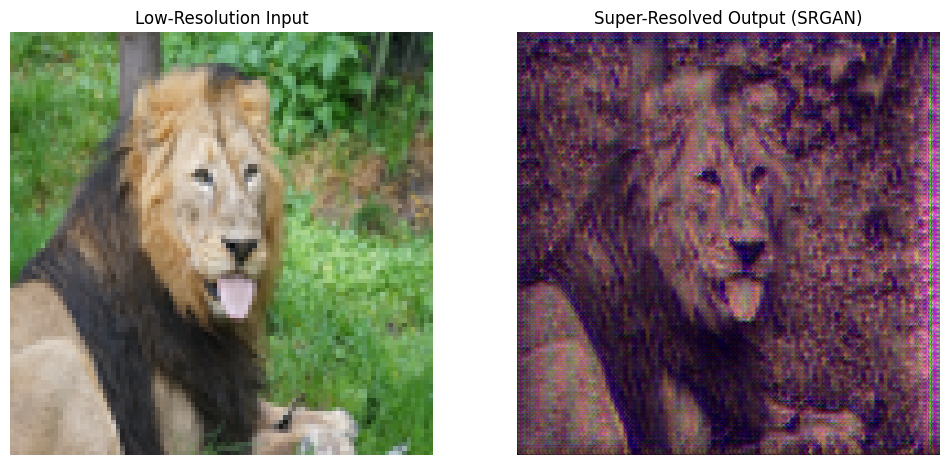

Super-Resolved image saved at: /content/drive/MyDrive/SRGAN_Results/SR_0809.png


In [7]:
# --- Step 0: Install required libraries ---
!pip install pillow

# --- Step 1: Import required modules ---
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- Step 2: Set device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Step 3: Paths setup ---
# Change these paths if needed
gen_model_path = '/content/drive/MyDrive/checkpoints/gen_epoch_50.pth'   # Path to saved Generator
lr_images_folder = '/content/drive/MyDrive/DIV2K_valid_HR/'                    # Folder with HR images to downscale to LR
output_folder = '/content/drive/MyDrive/SRGAN_Results/'                        # Folder to save results

os.makedirs(output_folder, exist_ok=True)

# --- Step 4: Load Generator Model ---
generator = Generator().to(device)
generator.load_state_dict(torch.load(gen_model_path, map_location=device))
generator.eval()
print("Generator model loaded successfully!")

# --- Step 5: Define transforms ---
transform_lr = transforms.Compose([
    transforms.ToTensor()
])

# --- Step 6: Load one (or more) LR images for testing ---
# You can change the filename to test different images
sample_image_name = '0809.png'  # Change as needed
lr_image_path = os.path.join(lr_images_folder, sample_image_name)

# Load the HR image
hr_image = Image.open(lr_image_path).convert('RGB')

# Manually create LR image by downscaling
lr_image = hr_image.resize((96, 96), Image.BICUBIC)  # Assuming your HR was 384x384 during training
lr_tensor = transform_lr(lr_image).unsqueeze(0).to(device)

# --- Step 7: Generate SR image ---
with torch.no_grad():
    sr_tensor = generator(lr_tensor)

# Convert tensors to images
sr_image = sr_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
lr_image_display = lr_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

# --- Step 8: Visualization ---
plt.figure(figsize=(12,6))

# Low-Resolution Input
plt.subplot(1,2,1)
plt.imshow(lr_image_display)
plt.title('Low-Resolution Input')
plt.axis('off')

# Super-Resolved Output
plt.subplot(1,2,2)
plt.imshow(sr_image)
plt.title('Super-Resolved Output (SRGAN)')
plt.axis('off')

plt.show()

# --- Step 9: Save the output SR image ---
# Convert SR tensor to PIL image and save
sr_image_save = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu().clamp(0,1))
output_image_path = os.path.join(output_folder, f"SR_{sample_image_name}")
sr_image_save.save(output_image_path)

print(f"Super-Resolved image saved at: {output_image_path}")
